# **Single-Cell RNA-Seq Analysis Project**

In this project, you will work with the `norman` dataset from the `perturbation_data_analysis` exercise:

In [49]:
import os
import sys

# Append the root of the Git repository to the path.
git_root = os.popen(cmd="git rev-parse --show-toplevel").read().strip()
sys.path.append(git_root)


from src.exercises.perturbation_data_analysis import pertdata as pt  # noqa: E402

norman = pt.PertData.from_repo(name="norman", save_dir="data")

print(norman)



Dataset directory already exists: data\norman
Loading dataset: norman
PertData object
    name: norman
    path: data\norman
    adata: AnnData object with n_obs x n_vars = 91205 x 5045


In [50]:
adata = norman.adata
adata

AnnData object with n_obs × n_vars = 91205 × 5045
    obs: 'condition', 'cell_type', 'dose_val', 'control', 'condition_name', 'condition_fixed'
    var: 'gene_name'
    uns: 'non_dropout_gene_idx', 'non_zeros_gene_idx', 'rank_genes_groups_cov_all', 'top_non_dropout_de_20', 'top_non_zero_de_20'
    layers: 'counts'

In [51]:
adata.obs.head()

,condition,cell_type,dose_val,control,condition_name,condition_fixed
cell_barcode,,,,,,
AAACCTGAGGCATGTG-1,TSC22D1+ctrl,A549,1+1,0,A549_TSC22D1+ctrl_1+1,TSC22D1
AAACCTGAGGCCCTTG-1,KLF1+MAP2K6,A549,1+1,0,A549_KLF1+MAP2K6_1+1,KLF1+MAP2K6
AAACCTGCACGAAGCA-1,ctrl,A549,1,1,A549_ctrl_1,ctrl
AAACCTGCAGACGTAG-1,CEBPE+RUNX1T1,A549,1+1,0,A549_CEBPE+RUNX1T1_1+1,CEBPE+RUNX1T1
AAACCTGCAGCCTTGG-1,MAML2+ctrl,A549,1+1,0,A549_MAML2+ctrl_1+1,MAML2


In [52]:
adata.var.head()

,gene_name
gene_id,
ENSG00000239945,RP11-34P13.8
ENSG00000223764,RP11-54O7.3
ENSG00000187634,SAMD11
ENSG00000187642,PERM1
ENSG00000188290,HES4


In [53]:
print(adata.obs.columns.tolist())

['condition', 'cell_type', 'dose_val', 'control', 'condition_name', 'condition_fixed']


In [85]:
print(adata.obs["condition"].value_counts().to_string())


condition
ctrl               7353
CEBPE+RUNX1T1      1030
KLF1+ctrl           997
TBX3+TBX2           969
SLC4A1+ctrl         853
ETS2+CNN1           785
DUSP9+ETS2          698
UBASH3B+OSR2        677
DUSP9+ctrl          662
ctrl+ETS2           656
ctrl+KLF1           644
ctrl+BAK1           637
ctrl+CEBPE          566
LYL1+IER5L          547
LHX1+ELMSAN1        547
ZC3HAV1+HOXC13      543
SET+KLF1            541
ZNF318+ctrl         541
CBL+ctrl            538
BAK1+ctrl           534
SET+CEBPE           529
ctrl+UBASH3B        513
SET+ctrl            512
MAML2+ctrl          508
FOSB+ctrl           502
MAP2K3+ELMSAN1      484
C19orf26+ctrl       480
AHR+ctrl            479
ctrl+FEV            474
CEBPE+ctrl          473
UBASH3B+ctrl        470
BCL2L11+ctrl        463
TMSB4X+ctrl         462
MAP2K3+ctrl         458
MAP2K3+MAP2K6       458
BCORL1+ctrl         456
ctrl+OSR2           451
FOXF1+ctrl          448
SGK1+ctrl           446
S1PR2+ctrl          446
SLC6A9+ctrl         441
ZC3HAV

In [55]:
adata.obs["control"].value_counts()

control
0    83852
1     7353
Name: count, dtype: int64

In [56]:
import scanpy as sc

# PCA (sparse-freundlich, kein scale)
sc.tl.pca(adata, svd_solver="randomized", zero_center=False)

In [57]:
adata.uns["pca"]["variance_ratio"][:5]


array([0.0073588 , 0.05133133, 0.03504888, 0.01979576, 0.01780374],
      dtype=float32)

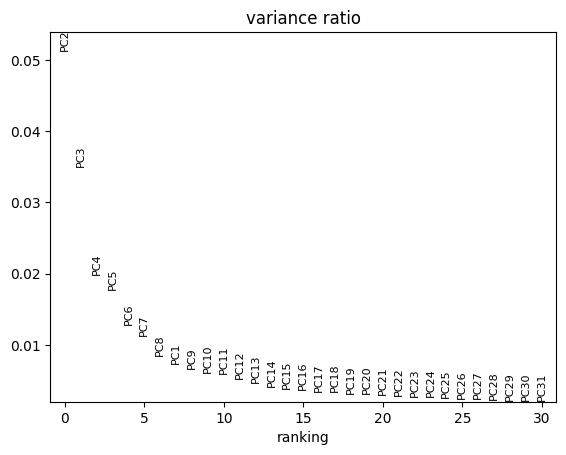

In [58]:
sc.pl.pca_variance_ratio(adata, log=False)


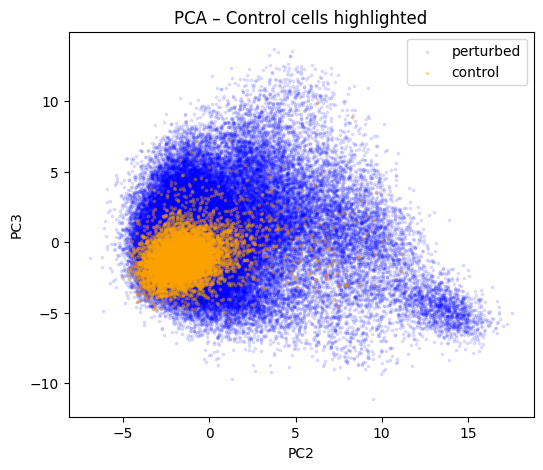

In [59]:
import matplotlib.pyplot as plt


X = adata.obsm["X_pca"][:, [1, 2]] # PC2, PC3
control_mask = adata.obs["control"] == 1

plt.figure(figsize=(6, 5))

# Hintergrund: alle Zellen
plt.scatter(
    X[:, 0], X[:, 1],
    s=3,
    c="blue",
    alpha=0.1,
    label="perturbed"
)

# Hervorheben: control
plt.scatter(
    X[control_mask, 0], X[control_mask, 1],
    s=3,
    c="orange",
    alpha=0.3,
    label="control"
)

plt.xlabel("PC2")
plt.ylabel("PC3")
plt.title("PCA – Control cells highlighted")
plt.legend()
#plt.xticks([])
#plt.yticks([])
plt.show()


Subcluster size: 1447


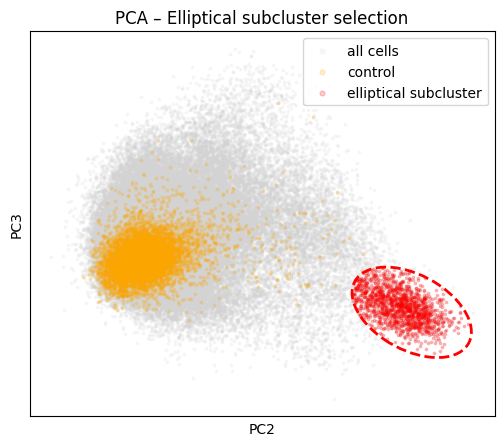

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# --- PCA coordinates (PC2, PC3) ---
X = adata.obsm["X_pca"][:, [1, 2]]
pc2 = X[:, 0]
pc3 = X[:, 1]

# --- control mask ---
control_mask = adata.obs["control"] == 1

# --- ellipse parameters (adjust if needed) ---
center_x, center_y = 14, -5
width = 8     # ellipse width (PC2 direction)
height = 5     # ellipse height (PC3 direction)
angle_deg = -40  # rotation angle in degrees

# --- compute elliptical mask ---
theta = np.deg2rad(angle_deg)
cos_t, sin_t = np.cos(theta), np.sin(theta)

# shift to ellipse center
x = pc2 - center_x
y = pc3 - center_y

# rotate points (inverse rotation)
x_rot = cos_t * x + sin_t * y
y_rot = -sin_t * x + cos_t * y

# ellipse equation
subcluster_mask = (
    (x_rot / (width / 2))**2 +
    (y_rot / (height / 2))**2
) <= 1

print("Subcluster size:", subcluster_mask.sum())

# --- plotting ---
plt.figure(figsize=(6, 5))

# all cells
plt.scatter(
    pc2, pc3,
    s=3,
    c="lightgray",
    alpha=0.15,
    label="all cells"
)

# control cells
plt.scatter(
    pc2[control_mask],
    pc3[control_mask],
    s=3,
    c="orange",
    alpha=0.2,
    label="control"
)

# elliptical subcluster
plt.scatter(
    pc2[subcluster_mask],
    pc3[subcluster_mask],
    s=3,
    c="red",
    alpha=0.2,
    label="elliptical subcluster"
)

# ellipse overlay
ellipse = Ellipse(
    (center_x, center_y),
    width=width,
    height=height,
    angle=angle_deg,
    edgecolor="red",
    facecolor="none",
    linewidth=2,
    linestyle="--"
)
plt.gca().add_patch(ellipse)

plt.xlabel("PC2")
plt.ylabel("PC3")
plt.title("PCA – Elliptical subcluster selection")
plt.legend(markerscale=2)
plt.xticks([])
plt.yticks([])
plt.show()

# store result in adata
adata.obs["pca_subcluster"] = "rest"
adata.obs.loc[subcluster_mask, "pca_subcluster"] = "subcluster"
adata.obs["pca_subcluster"] = adata.obs["pca_subcluster"].astype("category")


In [61]:
adata.obs["pca_subcluster"].value_counts()

pca_subcluster
rest          89758
subcluster     1447
Name: count, dtype: int64

In [62]:
adata.obs.head()

,condition,cell_type,dose_val,control,condition_name,condition_fixed,pca_subcluster
cell_barcode,,,,,,,
AAACCTGAGGCATGTG-1,TSC22D1+ctrl,A549,1+1,0,A549_TSC22D1+ctrl_1+1,TSC22D1,rest
AAACCTGAGGCCCTTG-1,KLF1+MAP2K6,A549,1+1,0,A549_KLF1+MAP2K6_1+1,KLF1+MAP2K6,rest
AAACCTGCACGAAGCA-1,ctrl,A549,1,1,A549_ctrl_1,ctrl,rest
AAACCTGCAGACGTAG-1,CEBPE+RUNX1T1,A549,1+1,0,A549_CEBPE+RUNX1T1_1+1,CEBPE+RUNX1T1,rest
AAACCTGCAGCCTTGG-1,MAML2+ctrl,A549,1+1,0,A549_MAML2+ctrl_1+1,MAML2,rest


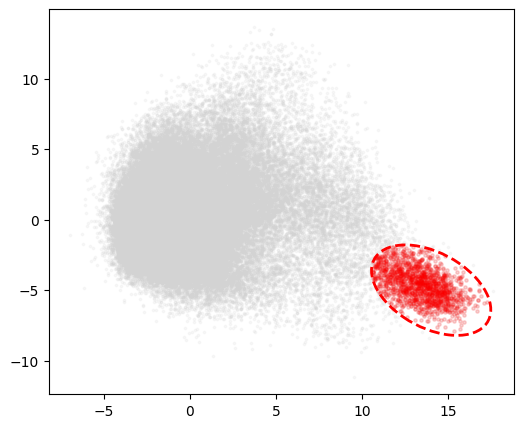

In [63]:
from matplotlib.patches import Ellipse

center = (14, -5)
width = 8   # x-Ausdehnung
height = 5  # y-Ausdehnung
angle = -40  # Rotation in Grad

ellipse = Ellipse(
    center,
    width=width,
    height=height,
    angle=angle,
    edgecolor="red",
    facecolor="none",
    linewidth=2,
    linestyle="--"
)

plt.figure(figsize=(6, 5))
plt.scatter(pc2, pc3, s=3, c="lightgray", alpha=0.15)
plt.scatter(pc2[subcluster_mask], pc3[subcluster_mask], s=6, c="red", alpha=0.15)
plt.gca().add_patch(ellipse)
plt.show()


In [64]:
import pandas as pd


pc2_loadings = adata.varm["PCs"][:, 1]  # PC2
genes = adata.var_names

pc2_df = pd.DataFrame({
    "gene": genes,
    "loading": pc2_loadings
})


In [65]:
pc2_df.sort_values("loading", ascending=False).head(20)

,gene,loading
2740,ENSG00000251562,0.145165
94,ENSG00000142669,0.124935
2738,ENSG00000245532,0.121848
1753,ENSG00000227706,0.108616
1663,ENSG00000204482,0.098273
2892,ENSG00000026025,0.095947
1664,ENSG00000204472,0.094838
4670,ENSG00000011600,0.093531
1960,ENSG00000130429,0.087372
3772,ENSG00000198736,0.084317


In [66]:
pc2_df.sort_values("loading", ascending=True).head(20)

,gene,loading
4825,ENSG00000108106,-0.134808
4842,ENSG00000099901,-0.122453
852,ENSG00000187514,-0.119509
331,ENSG00000173207,-0.116425
4209,ENSG00000239672,-0.115619
50,ENSG00000116649,-0.112655
1316,ENSG00000164104,-0.106890
3758,ENSG00000130656,-0.103250
2526,ENSG00000119403,-0.099770
2934,ENSG00000165732,-0.098327


In [67]:
adata_pert = adata[adata.obs["control"] == 0].copy()

In [68]:
adata_pert.obs["pca_subcluster"].value_counts()


pca_subcluster
rest          82405
subcluster     1447
Name: count, dtype: int64

In [69]:
import scanpy as sc

sc.pp.normalize_total(adata_pert, target_sum=1e4)
sc.pp.log1p(adata_pert)


In [70]:
sc.tl.rank_genes_groups(
    adata_pert,
    groupby="pca_subcluster",
    groups=["subcluster"],
    reference="rest",
    method="wilcoxon"
)


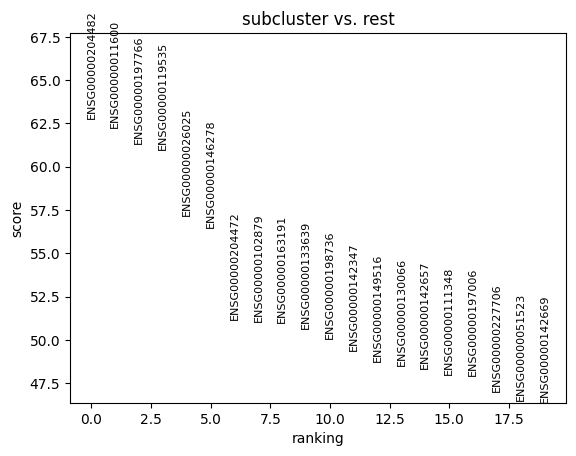

In [71]:
sc.pl.rank_genes_groups(
    adata_pert,
    n_genes=20,
    sharey=False
)


In [72]:
de_df = sc.get.rank_genes_groups_df(
    adata_pert,
    group="subcluster"
)

de_df.head(200000)


,names,scores,logfoldchanges,pvals,pvals_adj
0,ENSG00000204482,62.784119,5.959456,0.0,0.0
1,ENSG00000011600,62.273888,5.764748,0.0,0.0
2,ENSG00000197766,61.326748,2.579123,0.0,0.0
3,ENSG00000119535,60.952679,5.761438,0.0,0.0
4,ENSG00000026025,57.151535,2.110971,0.0,0.0
...,...,...,...,...,...
5040,ENSG00000239672,-58.060650,-4.408993,0.0,0.0
5041,ENSG00000198763,-58.572929,-0.481353,0.0,0.0
5042,ENSG00000187514,-61.229851,-1.556469,0.0,0.0
5043,ENSG00000099901,-61.996902,-1.770830,0.0,0.0


In [73]:
gene = "ENSG00000163563"  # eines deiner Gene

import numpy as np

expr_sub = adata_pert[
    adata_pert.obs["pca_subcluster"] == "subcluster",
    gene
].X

# sparse-safe Mittelwert
mean_expr = expr_sub.mean()
frac_nonzero = (expr_sub > 0).mean()

mean_expr, frac_nonzero


(np.float32(0.5654465), np.float64(0.17415342087076713))

type
other            408
heterogeneous     71
stable            21
Name: count, dtype: int64

Top stable genes:
                gene  logfoldchanges  frac_sub  frac_rest  frac_diff  \
66   ENSG00000115956        6.411769  0.597789   0.023991   0.573797   
101  ENSG00000204482        5.959456  0.984796   0.176725   0.808071   
116  ENSG00000011600        5.764748  0.973739   0.177635   0.796104   
118  ENSG00000119535        5.761438  0.955771   0.161107   0.794664   
147  ENSG00000092067        5.299075  0.718728   0.084522   0.634207   
157  ENSG00000107738        5.183497  0.595715   0.055810   0.539906   
173  ENSG00000102879        5.081258  0.825155   0.135975   0.689181   
185  ENSG00000149516        4.977924  0.796130   0.140343   0.655786   
190  ENSG00000160255        4.952695  0.576365   0.059305   0.517060   
210  ENSG00000146278        4.755117  0.911541   0.234330   0.677211   
213  ENSG00000142347        4.723703  0.808569   0.155901   0.652669   
285  ENSG00000111348   

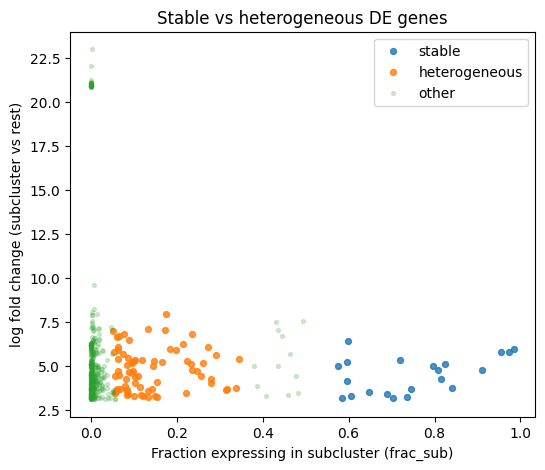

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse

# --- 0) Basis-Masken ---
mask_sub = (adata_pert.obs["pca_subcluster"] == "subcluster").values
mask_rest = (adata_pert.obs["pca_subcluster"] == "rest").values

# --- 1) Nimm eine sinnvolle Menge Gene (z.B. Top 500 nach logFC) ---
# (bei dir sind pvals oft 0, daher logFC als Ranking)
de_df_sorted = de_df.sort_values("logfoldchanges", ascending=False).copy()
genes = de_df_sorted["names"].head(500).tolist()

# --- 2) Indizes der Gene in adata_pert.var_names finden ---
# (falls ein Gen nicht gefunden wird, überspringen)
gene_to_idx = {g:i for i, g in enumerate(adata_pert.var_names)}
gene_idxs = [gene_to_idx[g] for g in genes if g in gene_to_idx]
genes_used = [g for g in genes if g in gene_to_idx]

# --- 3) Subsets der Matrix ziehen (sparse-safe) ---
X = adata_pert.X
if not sparse.issparse(X):
    X = sparse.csr_matrix(X)

X_sub = X[mask_sub, :][:, gene_idxs]
X_rest = X[mask_rest, :][:, gene_idxs]

n_sub = X_sub.shape[0]
n_rest = X_rest.shape[0]

# --- 4) frac_nonzero berechnen (Anteil > 0) ---
# Für sparse: (X > 0).sum(axis=0) zählt nicht-Nullen
frac_sub = np.asarray((X_sub > 0).sum(axis=0)).ravel() / n_sub
frac_rest = np.asarray((X_rest > 0).sum(axis=0)).ravel() / n_rest

# --- 5) mean expression berechnen (inkl. Nullen) ---
mean_sub = np.asarray(X_sub.mean(axis=0)).ravel()
mean_rest = np.asarray(X_rest.mean(axis=0)).ravel()

# --- 6) Alles in ein DataFrame packen ---
stats = pd.DataFrame({
    "gene": genes_used,
    "frac_sub": frac_sub,
    "frac_rest": frac_rest,
    "mean_sub": mean_sub,
    "mean_rest": mean_rest,
})

stats["frac_diff"] = stats["frac_sub"] - stats["frac_rest"]

# logFC aus deinem DE-DF mergen
stats = stats.merge(
    de_df_sorted[["names", "logfoldchanges", "scores", "pvals_adj"]],
    left_on="gene", right_on="names", how="left"
).drop(columns=["names"])

# --- 7) Heuristische Einteilung: stabil vs heterogen ---
# Du kannst diese Thresholds nach Gefühl anpassen:
STABLE_FRAC_MIN = 0.50      # mindestens 50% der Subcluster-Zellen exprimieren das Gen
STABLE_FRAC_DIFF = 0.20     # mindestens +20% häufiger als im Rest

HETEROG_FRAC_MAX = 0.35     # weniger als 35% im Subcluster exprimieren es
HETEROG_LOGFC_MIN = 2.0     # trotzdem deutlicher Effekt

stats["type"] = "other"

stats.loc[
    (stats["frac_sub"] >= STABLE_FRAC_MIN) &
    (stats["frac_diff"] >= STABLE_FRAC_DIFF),
    "type"
] = "stable"

stats.loc[
    (stats["type"] == "other") &
    (stats["frac_sub"] <= HETEROG_FRAC_MAX) &
    (stats["logfoldchanges"] >= HETEROG_LOGFC_MIN) &
    (stats["frac_diff"] >= 0.05),
    "type"
] = "heterogeneous"

print(stats["type"].value_counts())

# --- 8) Top-Beispiele ausgeben ---
stable_top = stats[stats["type"] == "stable"].sort_values("logfoldchanges", ascending=False).head(15)
hetero_top = stats[stats["type"] == "heterogeneous"].sort_values("logfoldchanges", ascending=False).head(15)

print("\nTop stable genes:")
print(stable_top[["gene","logfoldchanges","frac_sub","frac_rest","frac_diff","scores"]])

print("\nTop heterogeneous genes:")
print(hetero_top[["gene","logfoldchanges","frac_sub","frac_rest","frac_diff","scores"]])

# --- 9) Optional: Scatterplot zur Visualisierung (sehr hilfreich) ---
plt.figure(figsize=(6,5))
for t, a, s in [("stable", 0.8, 18), ("heterogeneous", 0.8, 18), ("other", 0.2, 8)]:
    df = stats[stats["type"] == t]
    plt.scatter(df["frac_sub"], df["logfoldchanges"], s=s, alpha=a, label=t)

plt.xlabel("Fraction expressing in subcluster (frac_sub)")
plt.ylabel("log fold change (subcluster vs rest)")
plt.title("Stable vs heterogeneous DE genes")
plt.legend()
plt.show()


In [75]:
top_genes = (
    de_df.query("scores > 10")
         .sort_values("logfoldchanges", ascending=False)
         .head(20)["names"]
         .tolist()
)

top_genes[:5], len(top_genes)

print(top_genes)


['ENSG00000163563', 'ENSG00000158517', 'ENSG00000122862', 'ENSG00000139278', 'ENSG00000257017', 'ENSG00000263961', 'ENSG00000105205', 'ENSG00000115956', 'ENSG00000169403', 'ENSG00000186652', 'ENSG00000156575', 'ENSG00000204482', 'ENSG00000116701', 'ENSG00000011600', 'ENSG00000119535', 'ENSG00000066294', 'ENSG00000082074', 'ENSG00000150681', 'ENSG00000092067', 'ENSG00000160593']


In [76]:
import numpy as np

np.random.seed(0)

sub_mask = (adata_pert.obs["pca_subcluster"] == "subcluster").values
rest_mask = (adata_pert.obs["pca_subcluster"] == "rest").values

sub_idx = np.where(sub_mask)[0]
rest_idx = np.where(rest_mask)[0]

# z.B. alle Subcluster-Zellen + 2000 Rest-Zellen
rest_sample = np.random.choice(rest_idx, size=min(2000, len(rest_idx)), replace=False)

keep_idx = np.concatenate([sub_idx, rest_sample])
adata_hm = adata_pert[keep_idx].copy()

adata_hm.obs["pca_subcluster"].value_counts()


pca_subcluster
rest          2000
subcluster    1447
Name: count, dtype: int64

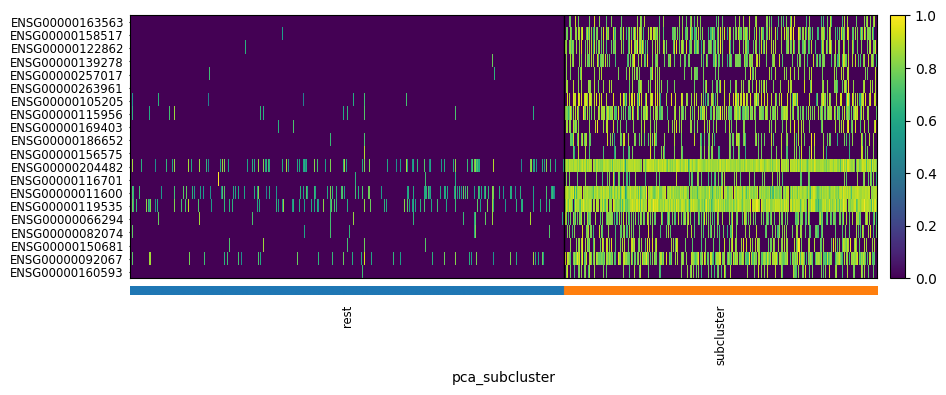

In [77]:
import scanpy as sc

sc.pl.heatmap(
    adata_hm,
    var_names=top_genes,
    groupby="pca_subcluster",
    swap_axes=True,
    show_gene_labels=True,
    standard_scale="var"  # z-score pro Gen -> sehr gut für Visualisierung
)


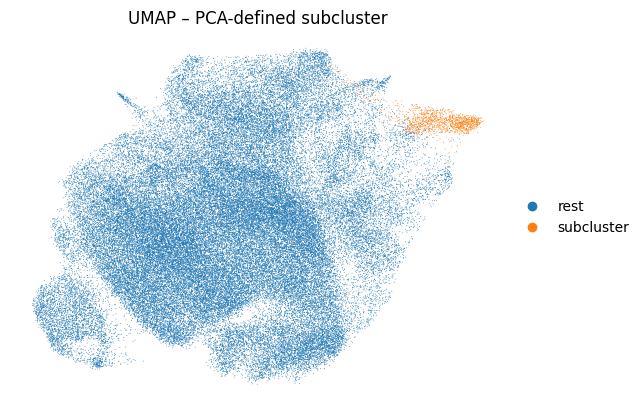

In [78]:
import scanpy as sc

# ------------------------------------------------------------
# 1) Nachbarschaftsgraph berechnen
#    (auf PCA-Basis, Standard für UMAP)
# ------------------------------------------------------------
sc.pp.neighbors(
    adata_pert,
    n_neighbors=15,
    n_pcs=30
)

# ------------------------------------------------------------
# 2) UMAP berechnen
# ------------------------------------------------------------
sc.tl.umap(adata_pert)

# ------------------------------------------------------------
# 3) UMAP plotten – Subcluster vs Rest
# ------------------------------------------------------------
sc.pl.umap(
    adata_pert,
    color="pca_subcluster",
    frameon=False,
    title="UMAP – PCA-defined subcluster"
)


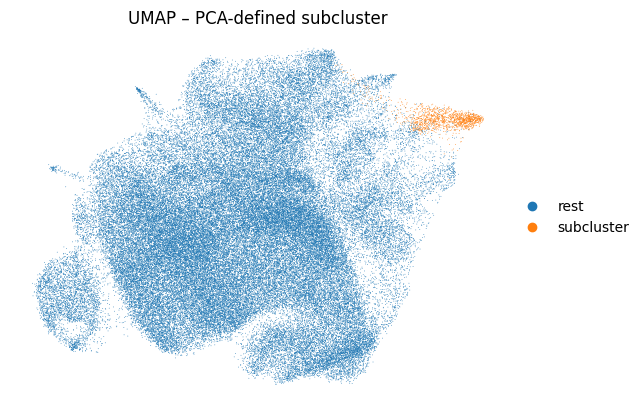

In [79]:
import scanpy as sc

# ------------------------------------------------------------
# 1) Nachbarschaftsgraph berechnen
#    (auf PCA-Basis, Standard für UMAP)
# ------------------------------------------------------------
sc.pp.neighbors(
    adata,
    n_neighbors=15,
    n_pcs=30
)

# ------------------------------------------------------------
# 2) UMAP berechnen
# ------------------------------------------------------------
sc.tl.umap(adata)

# ------------------------------------------------------------
# 3) UMAP plotten – Subcluster vs Rest
# ------------------------------------------------------------
sc.pl.umap(
    adata,
    color="pca_subcluster",
    frameon=False,
    title="UMAP – PCA-defined subcluster"
)


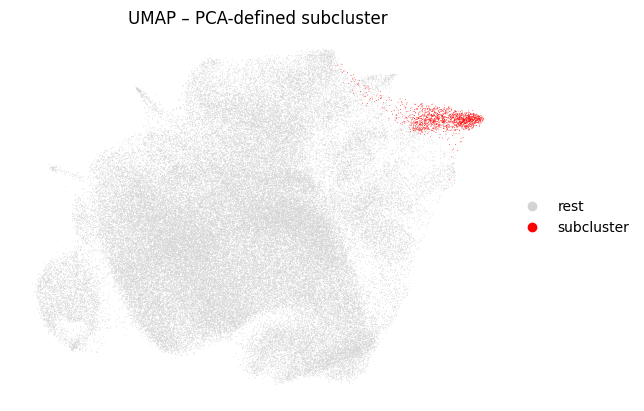

In [80]:
sc.pl.umap(
    adata,
    color="pca_subcluster",
    palette=["lightgrey","red"],
    frameon=False,
    title="UMAP – PCA-defined subcluster"
)

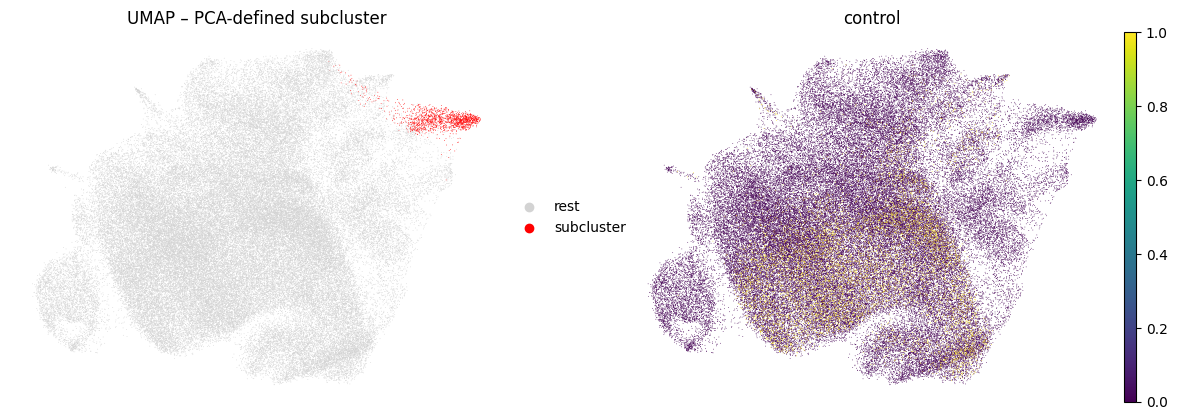

In [81]:

sc.pl.umap(
    adata,
    color=["pca_subcluster", "control"],
    frameon=False,
    title="UMAP – PCA-defined subcluster"
)

In [82]:
cond_col = "condition"  # <-- HIER anpassen!

sub = adata_pert.obs[adata_pert.obs["pca_subcluster"] == "subcluster"]

counts = sub[cond_col].value_counts(dropna=False)
perc = sub[cond_col].value_counts(normalize=True, dropna=False) * 100

summary = (counts.to_frame("count")
           .join(perc.to_frame("percent"))
           .sort_values("count", ascending=False))

print(summary.to_string())


                 count    percent
condition                        
CEBPA+ctrl         201  13.890809
ctrl+CEBPA         141   9.744299
CEBPE+CEBPA        130   8.984105
KLF1+CEBPA         105   7.256393
ctrl+CEBPE         102   7.049067
CEBPE+SPI1          68   4.699378
CEBPE+ctrl          68   4.699378
CEBPE+RUNX1T1       59   4.077402
ZC3HAV1+CEBPA       57   3.939185
FOSB+CEBPE          50   3.455425
JUN+CEBPA           42   2.902557
CEBPB+OSR2          41   2.833449
CEBPE+CEBPB         40   2.764340
FOSB+CEBPB          39   2.695232
CEBPB+CEBPA         38   2.626123
FOSB+OSR2           30   2.073255
CEBPB+ctrl          29   2.004147
ctrl+CEBPB          24   1.658604
ETS2+CEBPE          22   1.520387
CEBPB+MAPK1         15   1.036628
FOSB+ctrl           11   0.760194
CEBPE+KLF1          11   0.760194
ctrl+OSR2           10   0.691085
ZC3HAV1+CEBPE       10   0.691085
OSR2+ctrl            9   0.621977
JUN+CEBPB            8   0.552868
ETS2+MAPK1           7   0.483760
SET+CEBPE     

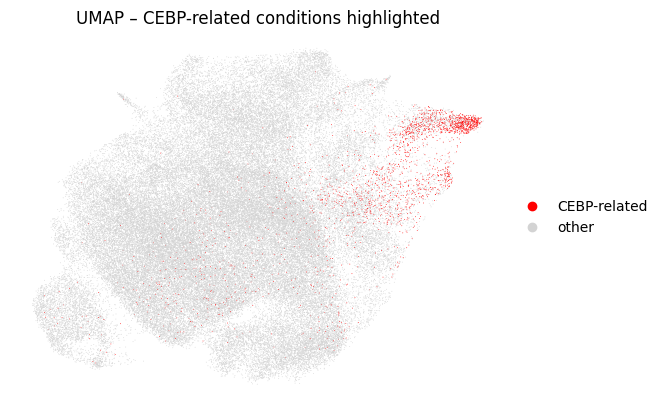

In [90]:
conditions_of_interest = [
    "CEBPA+ctrl", "ctrl+CEBPA",
    "CEBPE+ctrl", "ctrl+CEBPE",
    "CEBPB+ctrl", "ctrl+CEBPB",
    "CEBPE+CEBPA", "CEBPB+CEBPA"
]

conditions_of_interest = [
"CEBPA+ctrl", "ctrl+CEBPA",
"CEBPE+ctrl", "ctrl+CEBPE",
"CEBPB+ctrl", "ctrl+CEBPB",
"CEBPE+CEBPA", "CEBPB+CEBPA",
"KLF1+CEBPA",
"ZC3HAV1+CEBPA",
"JUN+CEBPA",
"CEBPE+SPI1",
"CEBPE+RUNX1T1",
"FOSB+CEBPE",
"CEBPE+CEBPB",
"ETS2+CEBPE",
"CEBPE+KLF1",
"ZC3HAV1+CEBPE",
"SET+CEBPE",
"CEBPE+CNN1",
"CEBPE+PTPN12",
"CEBPB+OSR2",
"FOSB+CEBPB",
"CEBPB+MAPK1",
"JUN+CEBPB",
"LYL1+CEBPB",
"CEBPB+PTPN12"
]

conditions_of_interest = [
"CEBPA+ctrl", "ctrl+CEBPA",
"CEBPE+CEBPA",
"KLF1+CEBPA",
"ctrl+CEBPE", "CEBPE+ctrl",
]

adata_pert.obs["cond_focus"] = "other"
adata_pert.obs.loc[
    adata_pert.obs["condition"].isin(conditions_of_interest),
    "cond_focus"
] = "CEBP-related"

sc.pl.umap(
    adata_pert,
    color="cond_focus",
    frameon=False,
    title="UMAP – CEBP-related conditions highlighted"
)


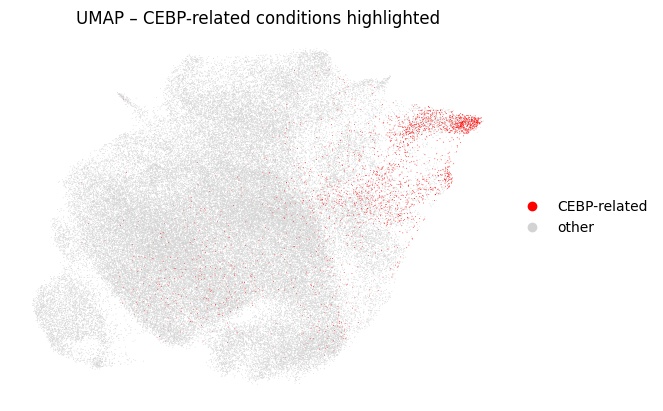

In [84]:
import scanpy as sc

sc.pl.umap(
    adata_pert,
    color="cond_focus",
    palette=["red","lightgrey"],
    frameon=False,
    title="UMAP – CEBP-related conditions highlighted"
)



Choose one of the following tasks:

~~**Exploratory Data Analysis and Visualization**

- Objective: Explore the dataset to identify patterns and clusters.
- Tasks:
  - Perform dimensionality reduction using PCA, t-SNE, or UMAP.
  - Visualize gene expression profiles across different conditions or perturbations.
  - Create heatmaps of the top differentially expressed genes.
- Learning Outcomes:
  - Learn to visualize high-dimensional data.
  - Interpret clusters and patterns in the context of biological conditions.~~

**Machine Learning Classification**

- Objective: Build models to classify samples based on gene expression profiles.
- Tasks:
  - Split the dataset into training and testing sets.
  - Implement classification algorithms.
  - Evaluate model performance using metrics like accuracy, precision, recall, and ROC curves.
- Learning Outcomes:
  - Understand supervised learning techniques.
  - Learn model evaluation and validation strategies.

**Advanced Deep Learning Applications**

- Objective: Apply deep learning techniques to model complex patterns in the data.
- Tasks:
  - Implement autoencoders or variational autoencoders for dimensionality reduction.
  - Explore the use of GANs to generate synthetic gene expression data.
  - Analyze how deep learning models capture nonlinear relationships.
- Learning Outcomes:
  - Gain experience with deep learning frameworks.
  - Understand the applications of deep learning in genomics.